In [2]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import scipy.stats
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator

from sklearn.metrics import r2_score
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [3]:

base_path = os.path.expanduser('/projects/EKOLEMEN/profile_predictor/run_results_02_27/')
"""good but overfit"""
#model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_01Mar20-19-50_Scenario-93.h5'
"""good val but looks bad?"""
# model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_01Mar20-02-31_Scenario-71.h5'
model_path = 'model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-target_density-pinj-tinj-curr_target_28Feb20-20-00_Scenario-19.h5'
file_path = base_path + model_path

"""THIS IS THE ONE FROM THE PAPER AS OF 3/5"""
file_path='/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'


# model = keras.models.load_model(file_path, compile=False)
# print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded dict: model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12_params.pkl
with parameters: dict_keys(['excluded_shots', 'model_type', 'epochs', 'model_kwargs', 'input_profile_names', 'target_profile_names', 'actuator_names', 'scalar_input_names', 'batch_size', 'process_data', 'predict_deltas', 'lookahead', 'profile_downsample', 'std_activation', 'sample_weighting', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'flattop_only', 'raw_data_path', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'nshots', 'lookbacks', 'sig_names', 'dt', 'normalization_dict', 'profile_length', 'mse_weight_vector', 'ru

In [4]:
scenario

{'excluded_shots': ['topology_TOP',
  'topology_OUT',
  'topology_MAR',
  'topology_IN',
  'topology_DN',
  'topology_BOT'],
 'model_type': 'conv2d',
 'epochs': 200,
 'model_kwargs': {'max_channels': 16},
 'input_profile_names': ['dens',
  'temp',
  'q_EFIT01',
  'rotation',
  'press_EFIT01'],
 'target_profile_names': ['dens',
  'temp',
  'q_EFIT01',
  'rotation',
  'press_EFIT01'],
 'actuator_names': ['curr_target', 'pinj', 'tinj', 'target_density', 'bt'],
 'scalar_input_names': ['density_estimate',
  'li_EFIT01',
  'volume_EFIT01',
  'triangularity_top_EFIT01',
  'triangularity_bot_EFIT01'],
 'batch_size': 128,
 'process_data': True,
 'predict_deltas': True,
 'lookahead': 4,
 'profile_downsample': 2,
 'std_activation': 'relu',
 'sample_weighting': 'std',
 'hinge_weight': 0,
 'mse_weight_power': 2,
 'mse_weight_edge': 10,
 'mse_power': 2,
 'flattop_only': True,
 'raw_data_path': '/scratch/gpfs/jabbate/new_data_EFIT02/final_data.pkl',
 'processed_filename_base': '/scratch/gpfs/jabbate/

In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                            inter_op_parallelism_threads=1,
                            allow_soft_placement=True,
                            device_count={'CPU': 1,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)


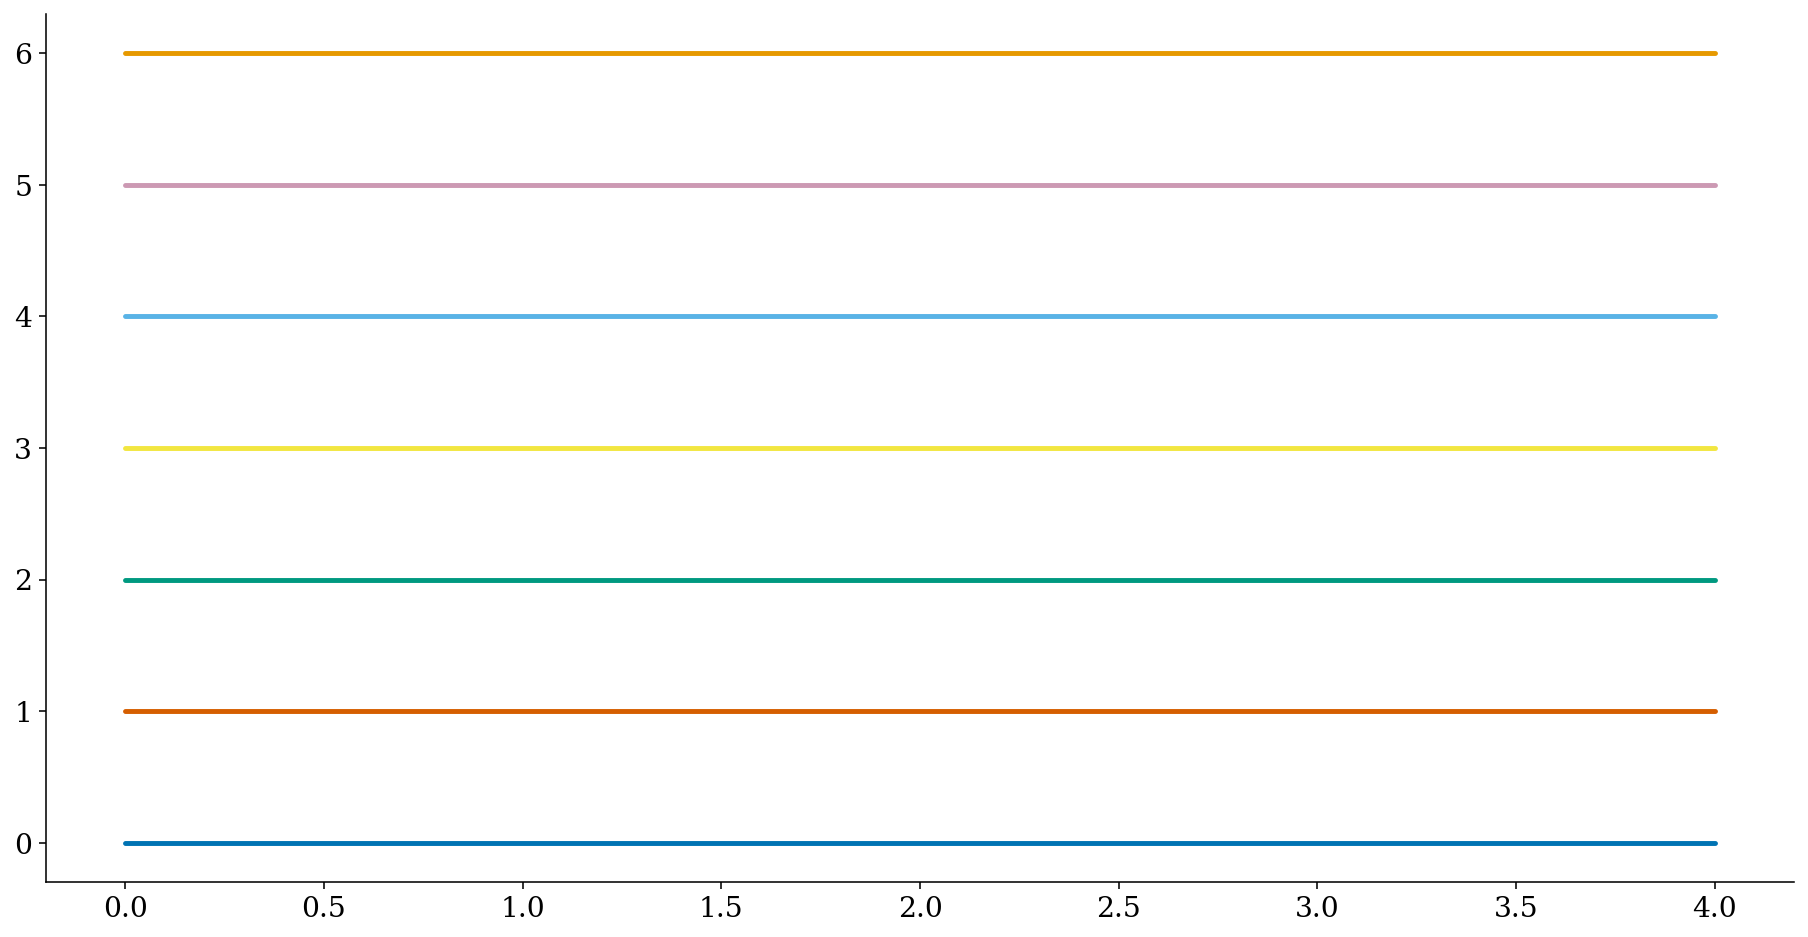

In [3]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
for i,c in enumerate(colorblind_colors):
    plt.plot((i)*np.ones(5),c=c)

In [13]:
base_path = '/projects/EKOLEMEN/profile_predictor/run_results_02_22/'
model_names = [# lowest MSE
    'model-conv1d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-22-05_Scenario-35',
    # lowest median abs err
    'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-19-51_Scenario-20',
    # low MSE wth press
    'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1-press_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-19-51_Scenario-19',
    # low med err with press
    'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1-press_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-18-56_Scenario-16',
    # lowest mse ignoring q
    'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-17-18_Scenario-11',
    # lowest median err ignoring q
    'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1-press_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-18-56_Scenario-16',
    # lowest non q mse with press
    'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1-press_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-18-56_Scenario-17'
    ]

In [14]:
model_names

['model-conv1d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-22-05_Scenario-35',
 'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-19-51_Scenario-20',
 'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1-press_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-19-51_Scenario-19',
 'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1-press_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-18-56_Scenario-16',
 'model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-17-18_Scenario-11',
 'model

In [15]:
models = []
scenarios = []

for name in model_names:
    model_path = base_path + name + '.h5'
    models.append(keras.models.load_model(model_path, compile=False))
    print('loaded model: ' + name)
    scenario_path = base_path + name + '_params.pkl'
    with open(scenario_path, 'rb') as f:
        scenarios.append(pickle.load(f, encoding='latin1'))

loaded model: model-conv1d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-22-05_Scenario-35
loaded model: model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-19-51_Scenario-20
loaded model: model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1-press_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-19-51_Scenario-19
loaded model: model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1-press_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-18-56_Scenario-16
loaded model: model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1_act-target_density-pinj-

In [16]:
orig_data_path = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
rt_test_data_path = '/scratch/gpfs/jabbate/test_rt/final_data.pkl'

profiles = ['thomson_dens_EFITRT1','thomson_temp_EFITRT1', 'cerquick_temp_EFITRT1','q_EFITRT1','cerquick_rotation_EFITRT1','ffprime_EFITRT1','press_EFITRT1']
scalars = ['density_estimate','li_EFITRT1','volume_EFITRT1','triangularity_top_EFITRT1','triangularity_bot_EFITRT1']
actuators = ['target_density','pinj','tinj','curr_target']
lookbacks = {sig:6 for sig in actuators+scalars}
lookbacks.update({sig:0 for sig in profiles})

traindata, valdata, normalization_dict = helpers.data_generator.process_data(rt_test_data_path,
                                                      sig_names = profiles + scalars + actuators,
                                                      normalization_method='RobustScaler',
                                                      window_length=1,
                                                      window_overlap=0,
                                                      lookbacks=lookbacks,
                                                      lookahead=4,
                                                      sample_step=1,
                                                      uniform_normalization=True,
                                                      train_frac=1,
                                                      val_frac=0,
                                                      nshots=12000,
                                                      verbose=2,
                                                      flattop_only=True,
                                                      randomize=False,
                                                      pruning_functions=['remove_nan','remove_dudtrip','remove_I_coil','remove_non_gas_feedback','remove_ECH'],
                                                      excluded_shots=['topology_TOP','topology_OUT','topology_MAR','topology_IN','topology_DN','topology_BOT','test_set'],
                                                      delta_sigs = [])


Loading
Signals: cerquick_rotation_EFITRT1, cerquick_temp_EFITRT1, curr_target, density_estimate, ffprime_EFITRT1, li_EFITRT1, pinj, press_EFITRT1, q_EFITRT1, target_density, thomson_dens_EFITRT1, thomson_temp_EFITRT1, tinj, triangularity_bot_EFITRT1, triangularity_top_EFITRT1, volume_EFITRT1
Number of useable shots:  1060
Number of shots used:  1060
Total number of timesteps:  124149
Shots with Complete NaN: 
83387 samples total
Removing ECH
Removed 46345 samples
37042 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 6320 samples
30722 samples remaining
Removing weird I-coils
Removed 6757 samples
23965 samples remaining
Removing NaN
Removed 0 samples
23965 samples remaining
Removing dudtrip
Removed 585 samples
23380 samples remaining
23380 samples remaining after pruning
Total number of samples:  23380
Number of training samples:  23380
Number of validation samples:  0


In [19]:
train_generator_batch = DataGenerator(traindata,
                                batch_size=128,
                                input_profile_names=profiles,
                                actuator_names=actuators,
                                target_profile_names=profiles,
                                scalar_input_names=scalars,
                                lookbacks=lookbacks,
                                lookahead=4,
                                predict_deltas=True,
                                profile_downsample=2,
                                shuffle=False,
                                sample_weights=None)

baseline = {sig:[] for sig in profiles}
for i in range(len(train_generator_batch)):
    print(i,end=',')
    sample = train_generator_batch[i]
    for sig in profiles:
        baseline[sig].append(sample[1]['target_'+sig])
baseline = {sig:np.concatenate(baseline[sig],axis=0) for sig in profiles}
baseline_err = {sig: np.abs(baseline[sig]) for sig in profiles}
med_baseline_err = {sig:np.median(baseline_err[sig]*normalization_dict[sig]['iqr'],axis=0) for sig in profiles}
med_baseline_lowper = {sig:np.percentile(baseline_err[sig]*normalization_dict[sig]['iqr'],25,axis=0) for sig in profiles}
med_baseline_hiper = {sig:np.percentile(baseline_err[sig]*normalization_dict[sig]['iqr'],75,axis=0) for sig in profiles}


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,

In [24]:
data = {i:{} for i in range(len(model_names))}

for idx, (model, scenario) in enumerate(zip(models,scenarios)):

    temp_train_generator = DataGenerator(traindata,
                                    128,
                                    scenario['input_profile_names'],
                                    scenario['actuator_names'],
                                    scenario['target_profile_names'],
                                    scenario['scalar_input_names'],
                                    scenario['lookbacks'],
                                    scenario['lookahead'],
                                    scenario['predict_deltas'],
                                    scenario['profile_downsample'],
                                    False,
                                    sample_weights = None)

    temp_predictions_arr = model.predict_generator(temp_train_generator, verbose=1)
    temp_predictions = {sig: arr for sig, arr in zip(scenario['target_profile_names'],temp_predictions_arr)}

    temp_baseline = {sig:[] for sig in profiles}
    for i in range(len(temp_train_generator)):
        sample = temp_train_generator[i]
        for sig in scenario['target_profile_names']:
            temp_baseline[sig].append(sample[1]['target_'+sig])
    temp_baseline = {sig:np.concatenate(temp_baseline[sig],axis=0) for sig in scenario['target_profile_names']}

    temp_model_err = {sig: np.abs(temp_predictions[sig] - temp_baseline[sig]) for sig in scenario['target_profile_names']}

    temp_med_model_err = {sig:np.median(temp_model_err[sig]*scenario['normalization_dict'][sig]['iqr'],axis=0) for sig in scenario['target_profile_names']}
    temp_med_model_hiper = {sig:np.percentile(temp_model_err[sig]*scenario['normalization_dict'][sig]['iqr'],75,axis=0) for sig in scenario['target_profile_names']}
    temp_med_model_lowper = {sig:np.percentile(temp_model_err[sig]*scenario['normalization_dict'][sig]['iqr'],25,axis=0) for sig in scenario['target_profile_names']}
    data[idx]['median'] = temp_med_model_err
    data[idx]['percentile75'] = temp_med_model_hiper
    data[idx]['percentile25'] = temp_med_model_lowper


183/183 [==============================] - 77s 420ms/step


/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The handle <matplotlib.lines.Line2D object at 0x200348e36c88> has a label of '_line1' which cannot be automatically added to the legend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The handle <matplotlib.lines.Line2D object at 0x200348e44048> has a label of '_line2' which cannot be automatically added to the legend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The handle <matplotlib.lines.Line2D object at 0x200348e44cc0> has a label of '_line4' which cannot be automatically added to the legend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The handle <matplotlib.lines.Line2D object at 0x200348e4f048> has a label of '_line5' which cannot be automatically added to the legend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packa

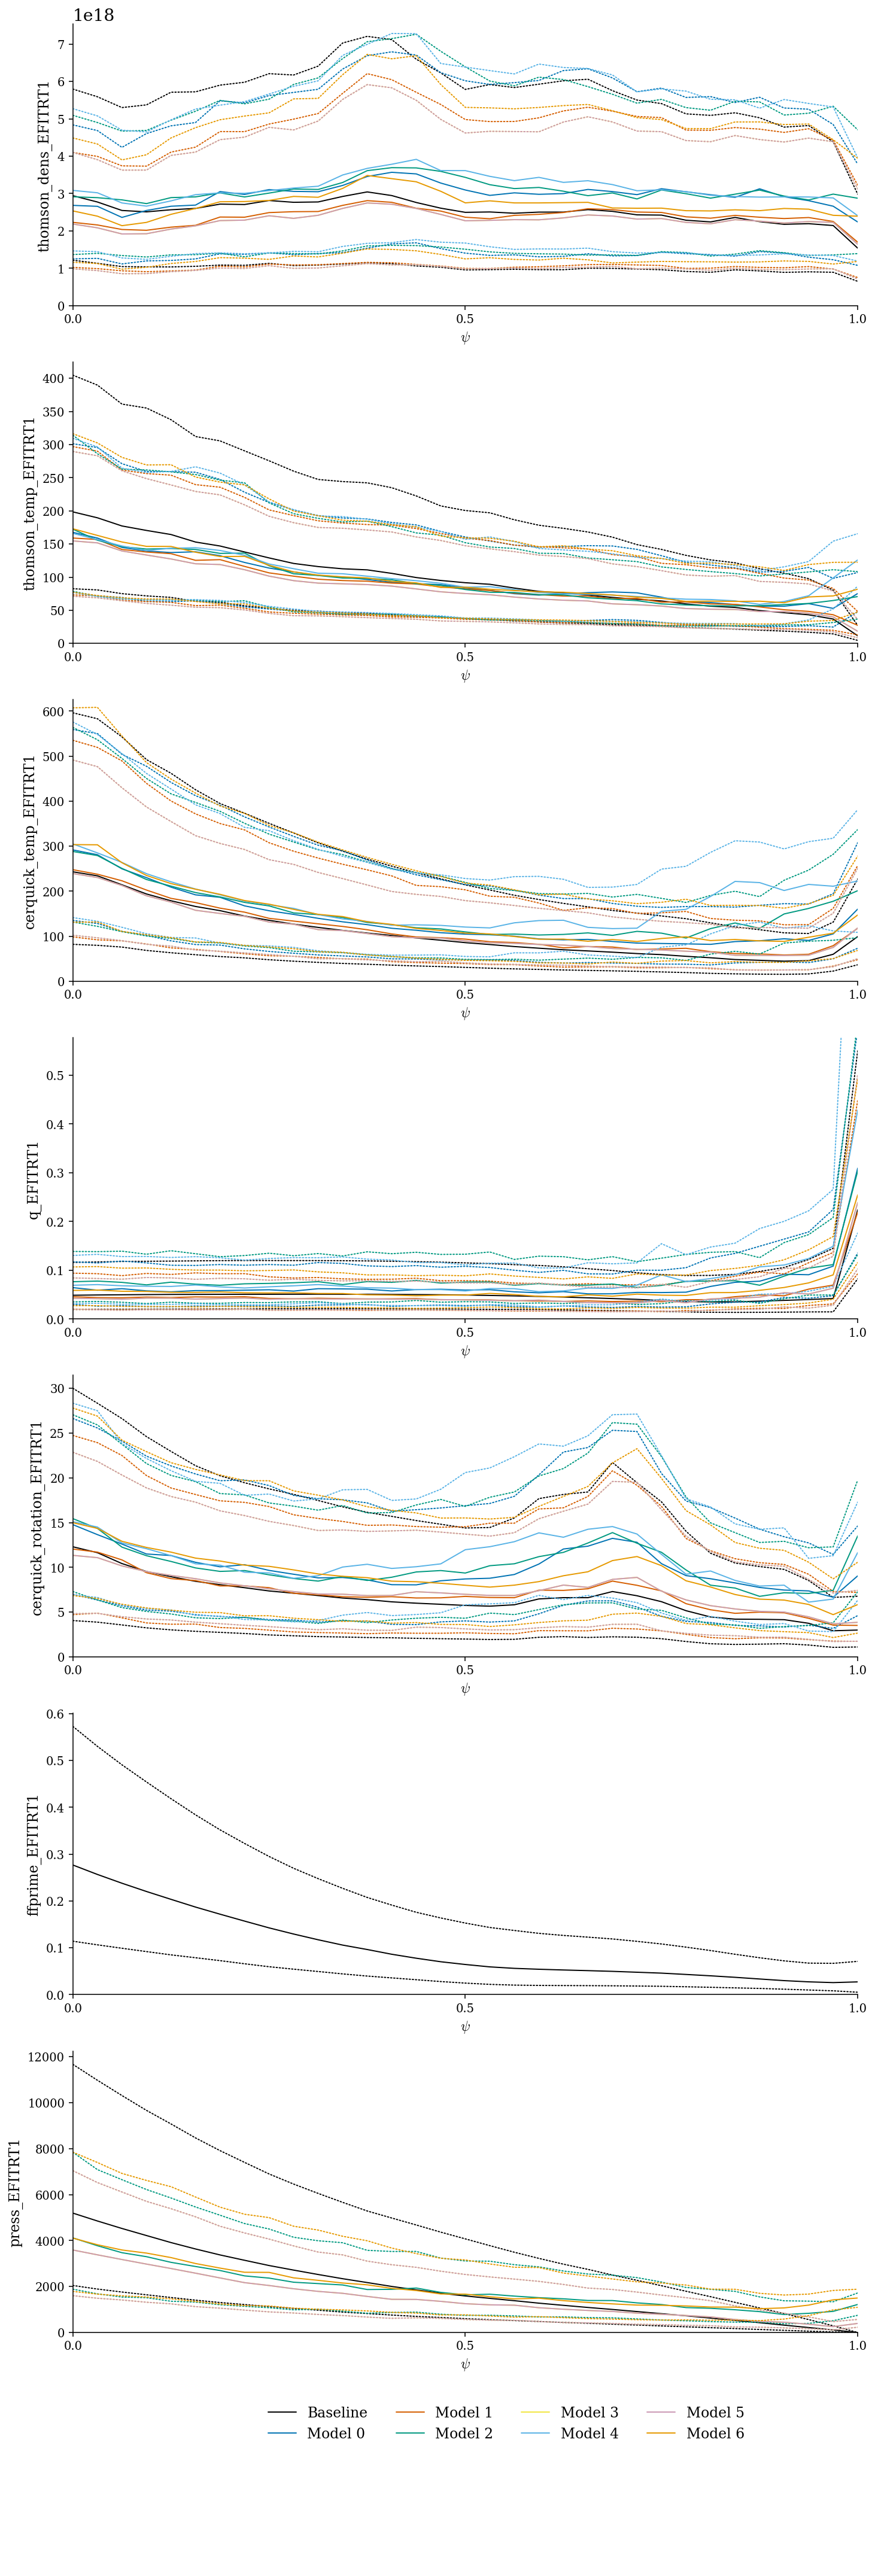

In [35]:
psi = np.linspace(0,1,33)

fig, ax = plt.subplots(len(profiles),1,figsize=(12,36))

for i, sig in enumerate(profiles):
    ax[i].plot(psi,med_baseline_err[sig].squeeze(),c='k', lw=1, label='Baseline')
    ax[i].plot(psi,med_baseline_lowper[sig].squeeze(), c='k', lw=1, linestyle=':')
    ax[i].plot(psi,med_baseline_hiper[sig].squeeze(), c='k', lw=1, linestyle=':')

    ax[i].set_ylabel(profiles[i],size=12)
    ax[i].set_ylim(0,None)
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].set_xticks([0,.5,1])
    ax[i].set_xlim(0,1)
    ax[i].set_xlabel('$\psi$',size=12)

    for idx, errs in data.items():
        if sig in errs['median']:
            ax[i].plot(psi,errs['median'][sig].squeeze(),c=colorblind_colors[idx],lw=1, label='Model {}'.format(idx))
            ax[i].plot(psi,errs['percentile25'][sig].squeeze(),c=colorblind_colors[idx], lw=1, linestyle=':')
            ax[i].plot(psi,errs['percentile75'][sig].squeeze(),c=colorblind_colors[idx], lw=1, linestyle=':')



plt.subplots_adjust(hspace=0.2, bottom=0.12)
fig.legend(handles=ax[0].lines,     
           labels=[line._label for line in ax[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.5, 0.06),
           frameon=False,
           mode=None,
           ncol=4,
          fontsize=12)


In [37]:
models[5].count_params()

946304

In [38]:
base_path + model_names[5] + '.h5'

'/projects/EKOLEMEN/profile_predictor/run_results_02_22/model-conv2d_profiles-thomson_dens_EFITRT1-thomson_temp_EFITRT1-cerquick_temp_EFITRT1-q_EFITRT1-cerquick_rotation_EFITRT1-press_EFITRT1_act-target_density-pinj-tinj-curr_target_23Feb20-18-56_Scenario-16.h5'